In [13]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tensorflow as tf

from xgboost import XGBClassifier
from tensorflow.keras import layers, optimizers, models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

base = "../data/Deployment_2/"

## 1. Data loading

In [14]:
data = pd.read_csv(base + "dataset_2_preprocessing_with_mean_value.csv")
df_train = data.copy()

## 2. Data processing

In [15]:
df_train = df_train.fillna(0)
df_train["Time"] = df_train["Hour"]*60 + df_train["Minute"]

df_train_without_ignore = df_train[df_train["Label"]!=10]
df_train_without_ignore = df_train_without_ignore.reset_index(drop=True)

In [16]:
df_train_without_ignore.head()

,TimeID,Hour,Minute,Date,Label,Name,sensor1,sensor2,sensor3,sensor4,...,sensor21,sensor22,sensor24,sensor30,sensor31,sensor32,sensor40,sensor41,sensor42,Time
0,2013-04-14-20-15,20,15,2013-04-14,2.0,Watching TV,0.0,0.0,0.0,194.000000,...,0.0,0.0,0.0,5.000000,12.304348,0.000000,0.0,1.478261,0.0,1215
1,2013-04-14-20-16,20,16,2013-04-14,2.0,Watching TV,0.0,0.0,0.0,194.666667,...,0.0,0.0,0.0,68.333333,12.250000,0.000000,0.0,1.416667,0.0,1216
2,2013-04-14-20-17,20,17,2013-04-14,2.0,Watching TV,208.0,0.0,0.0,195.000000,...,0.0,0.0,0.0,68.086957,11.956522,0.000000,0.0,1.391304,0.0,1217
3,2013-04-14-20-18,20,18,2013-04-14,2.0,Watching TV,0.0,0.0,0.0,196.000000,...,0.0,0.0,0.0,68.000000,12.043478,2.260870,0.0,1.478261,0.0,1218
4,2013-04-14-20-19,20,19,2013-04-14,2.0,Watching TV,0.0,0.0,0.0,197.833333,...,0.0,0.0,0.0,67.913043,11.833333,5.916667,0.0,1.478261,0.0,1219


In [17]:
# df_freq = pd.DataFrame(df_train["Date"].value_counts()).reset_index().sort_values(by="index")
# df_freq = df_freq.rename(columns={"index":"Date", "Date":"Count"})
# df_freq_1_hour = df_freq[df_freq["Count"]>60]
# df_freq_2_hour = df_freq[df_freq["Count"]>120]
# df_freq_1_hour

#### Filling "Ignore" by using the best action prediction model from part 1

In [18]:
encoder = LabelEncoder()

X = df_train_without_ignore.drop(["Label", "TimeID", "Date", "Name", "Hour", "Minute"], axis=1)
X = np.array(X)
y = encoder.fit_transform(df_train_without_ignore["Name"])

In [19]:
xgb_model = XGBClassifier(colsample_bytree=0.6, 
                          gamma=0, 
                          learning_rate=0.01, 
                          max_depth=4, 
                          n_estimators=190, 
                          subsample=0.9,
                          random_state=18)

xgb_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=190, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=18, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
xgb_model.score(X, y)

0.9332013504675375

In [21]:
df_ignore = df_train[df_train["Label"]==10]
df_ignore = df_ignore.reset_index(drop=True)
df_ignore = df_ignore.drop(["Label", "TimeID", "Date", "Name", "Hour", "Minute"], axis=1)

y_pred = xgb_model.predict(np.array(df_ignore))

In [22]:
df_train.loc[df_train["Label"]==10, "Name"] = encoder.inverse_transform(y_pred)

In [23]:
np.unique(df_train["Name"])

array(['Eating', 'Ironing', 'Listening Radio', 'Making Tea',
       'Not at Home', 'Reading', 'Sleeping', 'Slicing Bread',
       'Watching TV'], dtype=object)

### Preparing data for training

In [25]:
encoder = LabelEncoder()

train_data = df_train.drop(["Label", "TimeID", "Date", "Name", "Hour", "Minute"], axis=1)
train_data = np.array(train_data)
train_labels = encoder.fit_transform(df_train["Name"])

print(train_data.shape, train_labels.shape)

(89128, 17) (89128,)


In [28]:
def make_data(timesteps, ratio=0.5, train_data=train_data, train_labels=train_labels):
    X_data = np.zeros([train_data.shape[0]-timesteps, timesteps, train_data.shape[1]])
    y_data = train_labels[timesteps:]
    for i in range(timesteps):
        X_data[:,i,:] = train_data[i:X_data.shape[0]+i]
    
    split_idx = int(len(X_data)*ratio)

    X_train, X_test = X_data[:split_idx], X_data[split_idx:]
    y_train, y_test = y_data[:split_idx], y_data[split_idx:]
    
    return X_train, y_train, X_test, y_test 

## 3. Training

In [29]:
histories = []

for timesteps in [30, 60, 120]:
    X_train, y_train, X_test, y_test = make_data(timesteps)
    
    tf.keras.backend.clear_session()
    
    inputs = layers.Input(shape=(X_train.shape[1:]))
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.LSTM(128)(x)
    outputs = layers.Dense(9, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizers.Adam(),
                  metrics=["accuracy"])

    history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_test, y_test))
    histories.append(history)

Train on 44549 samples, validate on 44549 samples
Epoch 1/50
44549/44549 [==============================] - 6s 133us/sample - loss: 1.7233 - accuracy: 0.6603 - val_loss: 1.6351 - val_accuracy: 0.7363
Epoch 2/50
44549/44549 [==============================] - 1s 31us/sample - loss: 1.6125 - accuracy: 0.7606 - val_loss: 1.5685 - val_accuracy: 0.8062
Epoch 3/50
44549/44549 [==============================] - 1s 30us/sample - loss: 1.5553 - accuracy: 0.8185 - val_loss: 1.5539 - val_accuracy: 0.8185
Epoch 4/50
44549/44549 [==============================] - 1s 31us/sample - loss: 1.5461 - accuracy: 0.8268 - val_loss: 1.5197 - val_accuracy: 0.8528
Epoch 5/50
44549/44549 [==============================] - 1s 31us/sample - loss: 1.5269 - accuracy: 0.8457 - val_loss: 1.5366 - val_accuracy: 0.8354
Epoch 6/50
44549/44549 [==============================] - 1s 31us/sample - loss: 1.5487 - accuracy: 0.8240 - val_loss: 1.5528 - val_accuracy: 0.8195
Epoch 7/50
44549/44549 [==============================]

44534/44534 [==============================] - 2s 50us/sample - loss: 1.5295 - accuracy: 0.8432 - val_loss: 1.5485 - val_accuracy: 0.8238
Epoch 6/50
44534/44534 [==============================] - 2s 50us/sample - loss: 1.5503 - accuracy: 0.8222 - val_loss: 1.5559 - val_accuracy: 0.8177
Epoch 7/50
44534/44534 [==============================] - 2s 50us/sample - loss: 1.5285 - accuracy: 0.8441 - val_loss: 1.5378 - val_accuracy: 0.8340
Epoch 8/50
44534/44534 [==============================] - 2s 50us/sample - loss: 1.5331 - accuracy: 0.8391 - val_loss: 1.5539 - val_accuracy: 0.8185
Epoch 9/50
44534/44534 [==============================] - 2s 50us/sample - loss: 1.5221 - accuracy: 0.8501 - val_loss: 1.5568 - val_accuracy: 0.8153
Epoch 10/50
44534/44534 [==============================] - 2s 50us/sample - loss: 1.5203 - accuracy: 0.8521 - val_loss: 1.5441 - val_accuracy: 0.8279
Epoch 11/50
44534/44534 [==============================] - 2s 50us/sample - loss: 1.5166 - accuracy: 0.8558 - val_lo

In [30]:
def plot(epochs, history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    legends = ["training", "validation"]
    print(f"Highest accuracy {np.max(val_acc)} at epoch {np.argmax(val_acc) + 1}")
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs = axs.flatten()
    axs[0].plot(np.arange(1,epochs+1), acc, marker="o")
    axs[0].plot(np.arange(1,epochs+1), val_acc, marker="D")
    axs[0].legend(legends)
    axs[0].grid(True)
    
    axs[1].plot(np.arange(1,epochs+1), loss, marker="o")
    axs[1].plot(np.arange(1,epochs+1), val_loss, marker="D")
    axs[1].legend(legends)
    axs[1].grid(True)
    
    plt.show()

## 4. Evaluation

Highest accuracy 0.8609172105789185 at epoch 44


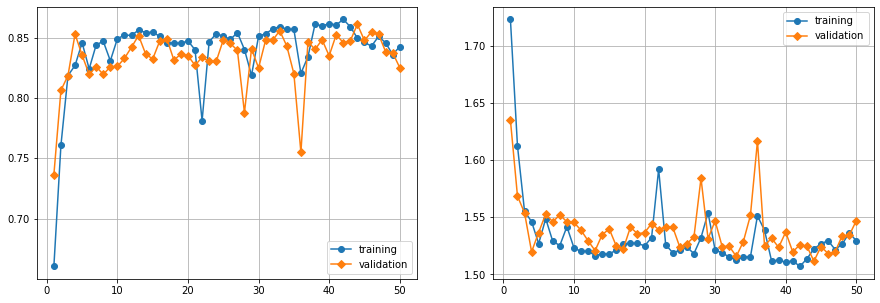

In [31]:
plot(50, histories[0])

Highest accuracy 0.8530560731887817 at epoch 14


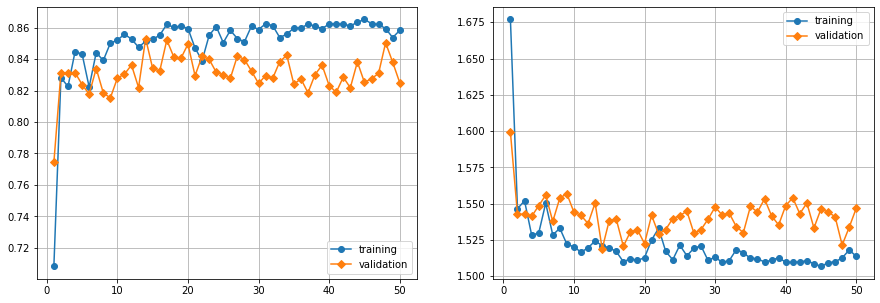

In [32]:
plot(50, histories[1])

Highest accuracy 0.8587093353271484 at epoch 41


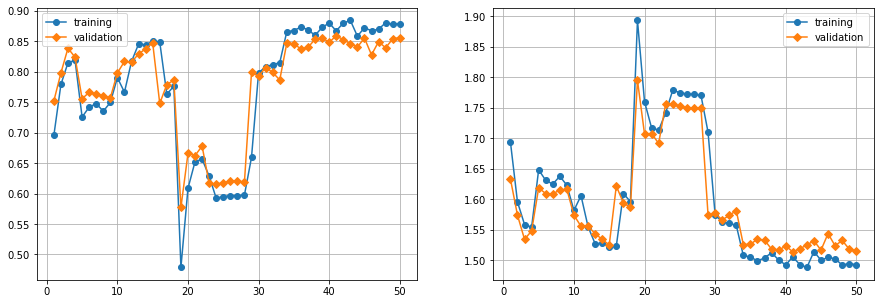

In [33]:
plot(50, histories[2])